## Stroke Detection

In this stage we estimate the likelihood of a stroke based on speech characteristics :

**Speech‑based dysarthria detection:** Slurred or impaired speech is a hallmark of stroke.  We can extract acoustic features from the audio and train a classifier (e.g. Random Forest) on a dysarthric speech dataset such as TORGO or UASpeech.

In [1]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("iamhungundji/dysarthria-detection")

# print("Path to dataset files:", path)

In [2]:
import os, re, glob, json, time, warnings
warnings.filterwarnings("ignore")

import numpy as np
import librosa
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from joblib import dump

# -----------------------
# CONFIG
# -----------------------
DATA_DIR = "/home/sraja/.cache/kagglehub/datasets/iamhungundji/dysarthria-detection/versions/1"

DYS_SPEAKERS     = {"F01", "F03", "F04", "M01", "M02", "M03"} 
HEALTHY_SPEAKERS = {"FC01", "FC02", "MC01", "MC02"} 

KEYWORDS_DYS = ("dys", "dysarth")     # path contains any → label=1
KEYWORDS_CTL = ("control", "healthy") # path contains any → label=0

# Audio extensions to include:
EXTS = (".wav", ".flac", ".mp3", ".ogg")

# Feature parameters
SAMPLE_RATE = 16_000
N_MFCC = 13 

# Cache features to speed up re-runs (creates .npy alongside audio)
ENABLE_FEATURE_CACHE = False



In [3]:
# -----------------------
# HELPERS
# -----------------------
spk_regex = re.compile(r"(?:^|/)([FM][C]?\d{2})(?:/|_)")  # matches F01, M03, FC01, MC02 etc.

def extract_speaker_id(path: str) -> str:
    m = spk_regex.search(path.replace("\\", "/"))
    return m.group(1) if m else os.path.basename(os.path.dirname(path))

def label_from_path(path: str, speaker_id: str) -> int | None:
    # Priority 1: explicit speaker lists
    if speaker_id in DYS_SPEAKERS: return 1
    if speaker_id in HEALTHY_SPEAKERS: return 0
    # Priority 2: keywords
    p = path.lower()
    if any(k in p for k in KEYWORDS_DYS): return 1
    if any(k in p for k in KEYWORDS_CTL): return 0
    return None  # unknown

def list_audio_files(root: str, exts=EXTS) -> list[str]:
    files = []
    for ext in exts:
        files.extend(glob.glob(os.path.join(root, "**", f"*{ext}"), recursive=True))
    return sorted(files)

def feat_cache_path(audio_path: str) -> str:
    base_dir = os.path.dirname(audio_path)
    if not base_dir:
        base_dir = "cache_feats"
    os.makedirs(base_dir, exist_ok=True)
    return os.path.splitext(audio_path)[0] + f".mfcc{N_MFCC}.sr{SAMPLE_RATE}.npy"

def extract_features(audio_path: str, n_mfcc: int = N_MFCC, sr: int = SAMPLE_RATE) -> np.ndarray:
    """Extract MFCCs -> mean over time (shape: [n_mfcc]). Uses cache if enabled."""
    if ENABLE_FEATURE_CACHE:
        cache = feat_cache_path(audio_path)
        if os.path.exists(cache):
            return np.load(cache)
    y, sr = librosa.load(audio_path, sr=sr)
    # trim leading/trailing silence to reduce noise
    y, _ = librosa.effects.trim(y, top_db=25)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    x = mfcc.mean(axis=1).astype(np.float32)
    if ENABLE_FEATURE_CACHE:
        os.makedirs(os.path.dirname(cache), exist_ok=True)
        np.save(cache, x)
    return x

In [4]:
# -----------------------
# LOAD DATA
# -----------------------
all_wavs = list_audio_files(DATA_DIR, EXTS)
if not all_wavs:
    raise FileNotFoundError(f"No audio found under {DATA_DIR}. Check DATA_DIR and extensions {EXTS}")

X, y, groups, paths = [], [], [], []
skipped = 0
for ap in all_wavs:
    sid = extract_speaker_id(ap)
    lab = label_from_path(ap, sid)
    if lab is None:
        skipped += 1
        continue
    try:
        X.append(extract_features(ap))
        y.append(lab)
        groups.append(sid)
        paths.append(ap)
    except Exception as e:
        skipped += 1

X = np.vstack(X)
y = np.asarray(y, dtype=np.int64)
groups = np.asarray(groups)

print(f"Loaded features: {X.shape}, dysarthric={int(y.sum())}, healthy={int((y==0).sum())}, skipped={skipped}")

Loaded features: (1996, 13), dysarthric=1478, healthy=518, skipped=1


In [5]:
# -----------------------
# TRAIN / VAL SPLIT (by speaker)
# -----------------------
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
(train_idx, val_idx), = gss.split(X, y, groups)

X_train, X_val = X[train_idx], X[val_idx]
y_train, y_val = y[train_idx], y[val_idx]

# -----------------------
# MODEL (SVM with RBF) + scaling
# -----------------------
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="rbf", probability=True, class_weight="balanced"))
])

param_grid = {
    "svm__C": [0.5, 1, 2, 4],
    "svm__gamma": ["scale", 0.01, 0.001]
}

clf = GridSearchCV(pipe, param_grid=param_grid, cv=3, n_jobs=-1, scoring="roc_auc", refit=True)
clf.fit(X_train, y_train)

print(f"Best params: {clf.best_params_}")

Best params: {'svm__C': 4, 'svm__gamma': 'scale'}


In [6]:
y_pred = clf.predict(X_val)
acc = accuracy_score(y_val, y_pred)
print(f"Validation accuracy: {acc:.3f}")

try:
    y_prob = clf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_prob)
    print(f"Validation ROC-AUC: {auc:.3f}")
except Exception:
    y_prob = None
    print("Validation ROC-AUC: n/a (single class in val set?)")

print("\nClassification report:")
print(classification_report(y_val, y_pred, target_names=["healthy(0)","dysarthric(1)"]))
print("Confusion matrix:\n", confusion_matrix(y_val, y_pred))

Validation accuracy: 0.696
Validation ROC-AUC: 0.788

Classification report:
               precision    recall  f1-score   support

   healthy(0)       0.94      0.46      0.61       169
dysarthric(1)       0.61      0.97      0.75       150

     accuracy                           0.70       319
    macro avg       0.78      0.71      0.68       319
 weighted avg       0.79      0.70      0.68       319

Confusion matrix:
 [[ 77  92]
 [  5 145]]


In [7]:
os.makedirs("models", exist_ok=True)
model_path = "models/torgo_speech_svc.joblib"
dump({
    "model": clf.best_estimator_,
    "params": clf.best_params_,
    "n_mfcc": N_MFCC,
    "sr": SAMPLE_RATE,
    "label_map": {"healthy": 0, "dysarthric": 1}
}, model_path)
print(f"\nSaved model → {model_path}")


Saved model → models/torgo_speech_svc.joblib


In [8]:
CALL_WAV = "dysarthria.wav"
def predict_stroke_probability(model_obj, audio_path: str) -> float:
    x = extract_features(audio_path).reshape(1, -1)
    return float(model_obj.predict_proba(x)[0, 1])

if CALL_WAV and os.path.exists(CALL_WAV):
    from joblib import load
    pack = load(model_path)
    svc = pack["model"]
    prob = predict_stroke_probability(svc, CALL_WAV)
    print(f"\nSpeech-based stroke probability for '{CALL_WAV}': {prob:.2%}")
else:
    if CALL_WAV:
        print(f"\nCALL_WAV not found at '{CALL_WAV}'. Skipping demo prediction.")


Speech-based stroke probability for 'dysarthria.wav': 97.58%


## Waveform

- Raw amplitude of the patient’s speech over ~4 minutes.

- Lets you see pauses, bursts of speech, and silence.

- For dysarthria detection, irregular patterns or fragmented speech segments are important.

## Mel-Spectrogram

- Frequency content of speech (y-axis = frequency bins, x-axis = time).

- Color shows intensity (louder = brighter).

- Dysarthric speech often has distorted and weaker harmonics, visible as patchy or smeared bands compared to normal speech.

## MFCCs

- Compressed acoustic features that capture timbre and articulation.

- MFCCs are what your model actually uses as input.

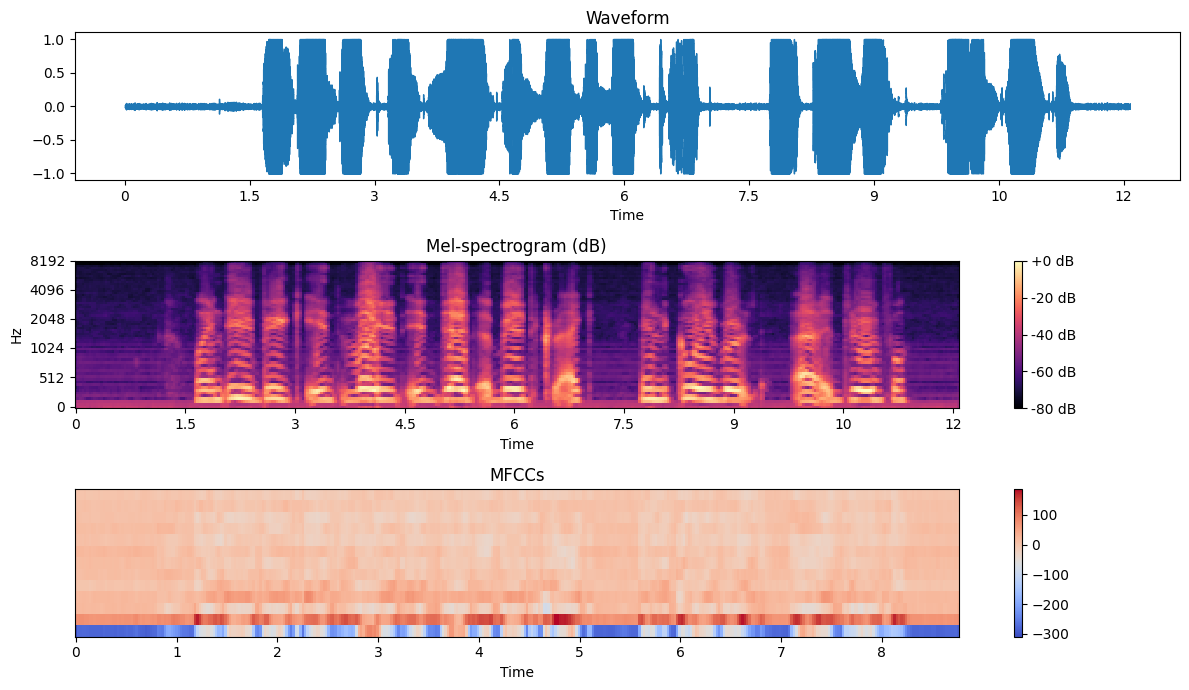

In [9]:
import librosa, librosa.display, numpy as np, matplotlib.pyplot as plt

y, sr = librosa.load(CALL_WAV, sr=16000)
mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64)
mel_db = librosa.power_to_db(mel, ref=np.max)
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

plt.figure(figsize=(12,7))
plt.subplot(3,1,1); plt.title("Waveform"); librosa.display.waveshow(y, sr=sr)
plt.subplot(3,1,2); plt.title("Mel-spectrogram (dB)")
librosa.display.specshow(mel_db, sr=sr, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.0f dB")
plt.subplot(3,1,3); plt.title("MFCCs"); librosa.display.specshow(mfcc, x_axis="time")
plt.colorbar(); plt.tight_layout(); plt.show()

## Model Confidence Over Time

- The plot shows how the model’s probability of “dysarthria” changes over time.

- The gray dashed line at 0.5 is the decision threshold.

- For each short segment of speech, the model outputs confidence.

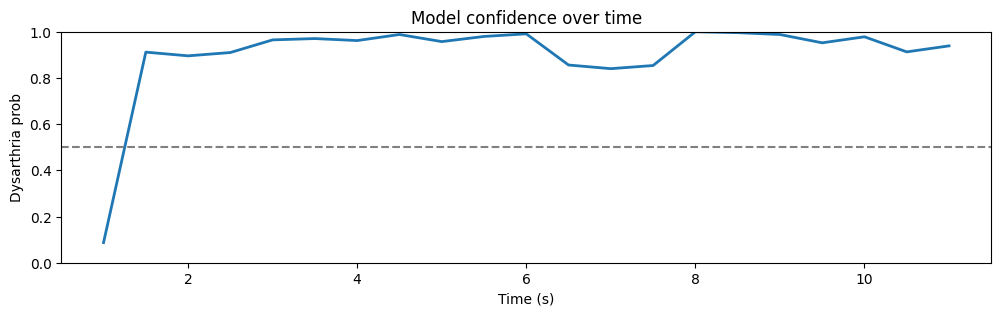

In [10]:
import numpy as np, matplotlib.pyplot as plt

win_sec, hop_sec = 2.0, 0.5
win, hop = int(win_sec*sr), int(hop_sec*sr)
probs, times = [], []
for start in range(0, len(y)-win, hop):
    seg = y[start:start+win]
    mf = librosa.feature.mfcc(y=seg, sr=sr, n_mfcc=13).mean(axis=1).reshape(1,-1)
    p = clf.predict_proba(mf)[0,1]  # 1 = dysarthric
    probs.append(p); times.append(start/sr + win_sec/2)

plt.figure(figsize=(12,3))
plt.plot(times, probs, lw=2); plt.ylim(0,1)
plt.axhline(0.5, ls="--", c="gray"); plt.xlabel("Time (s)"); plt.ylabel("Dysarthria prob")
plt.title("Model confidence over time"); plt.show()

## Influential Time Regions on Spectrogram

- This overlays a white curve on top of the spectrogram.

- The higher the curve → the more influential that time window was for the model’s decision.

- Essentially, this is an attention map: “Here’s where the model was really listening.”

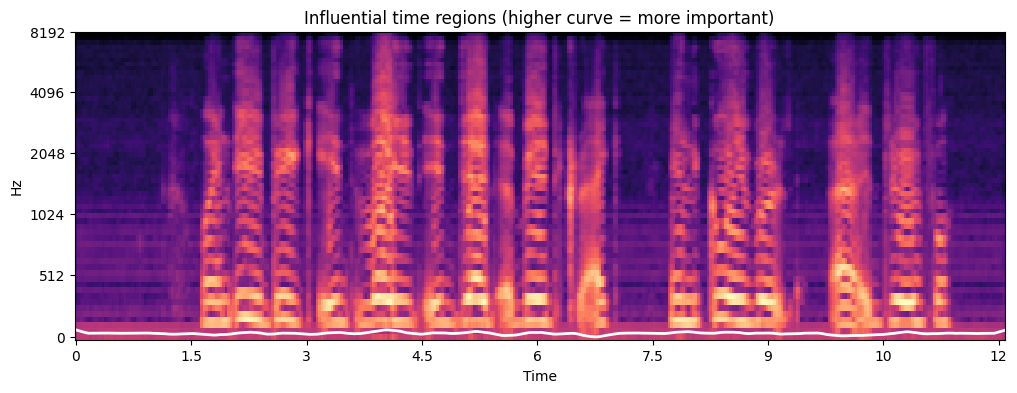

In [11]:
# DEMO: saliency via occlusion on MFCC frames (drop frames and see Δprob)
import numpy as np, matplotlib.pyplot as plt

mfcc_full = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # (13, T)
base_p = clf.predict_proba(mfcc_full.mean(axis=1).reshape(1,-1))[0,1]
T, k = mfcc_full.shape[1], 5  # occlusion window = 5 frames
delta = np.zeros(T)

for t in range(T):
    occl = mfcc_full.copy()
    occl[:, max(0,t-k):min(T,t+k)] = 0.0
    p = clf.predict_proba(occl.mean(axis=1).reshape(1,-1))[0,1]
    delta[t] = base_p - p  # drop in prob when region is removed

# normalize safely for plotting
d = (delta - delta.min()) / (np.ptp(delta) + 1e-6)

# overlay on mel-spec
plt.figure(figsize=(12,4))
librosa.display.specshow(mel_db, sr=sr, x_axis="time", y_axis="mel")
tt = np.linspace(0, len(y)/sr, T)
plt.plot(tt, d*(mel_db.shape[0]*0.9), c='w', lw=2)  # white curve near top
plt.title("Influential time regions (higher curve = more important)")
plt.show()
